<div class="alert alert-block alert-info"> <b>NOTE</b> 

<div>
    This is a duplicate of notebook <b>04_prediction.ipynb </b>
    in this notebook we load the normalization weights to realize prediction with the new models.
</div>
</div>

In [1]:
import matplotlib.pyplot as plt
from auxiliary_functions import load_joblib
from evaluation_metrics import oscillation_red

# For testing data

In [2]:
#Load the model and data
lag = 40
model = 'xgb'
path_to_read1 = f'/Users/luisescobar/Documents/Thesis/Models/TOP5_exp/{model}/lag_{lag}min'
#path_to_read1 = '/Users/luisescobar/Documents/Thesis/Models/Best_Models'
path_to_read2 = '/Users/luisescobar/Documents/Thesis/DataSets/Dictionary/03_01_Train_Val_Test'
path_to_save = f'/Users/luisescobar/Documents/Thesis/Images/TOP5_exp/{model}/lag_{lag}min'
#path_to_read3 = '/Users/luisescobar/Documents/Thesis/Models'
filename_model = f'{model}_model.pkl'
filename_clot = 'blocking_20.pkl'
filename_noclot = 'no_blocking_20.pkl'
filename_scaler = 'scaler.pkl'

#model_loaded = load_joblib(path_to_read1, filename_model)
model_loaded = load_joblib(path_to_read1, filename_model)
scaler_loaded = load_joblib(path_to_read1, filename_scaler)
clot_dict = load_joblib(path_to_read2, filename_clot)
no_clot_dict = load_joblib(path_to_read2, filename_noclot)


# For one sample

In [3]:
clot_dict.keys()

dict_keys(['df_1', 'df_923', 'df_680-df_681-concat', 'df_654', 'df_311', 'df_344-df_345-df_346-concat', 'df_902', 'df_486', 'df_513', 'df_62', 'df_653', 'df_783', 'df_790', 'df_247', 'df_190', 'df_751', 'df_764', 'df_859', 'df_115'])

<div class="alert alert-block alert-danger"> Line 21 and 22 must be commented when working with a model that considers 'DeltaP', 'TMP', 'TMPa'</div>


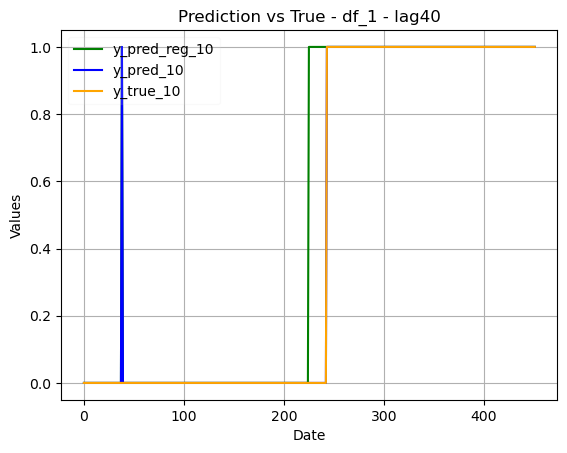

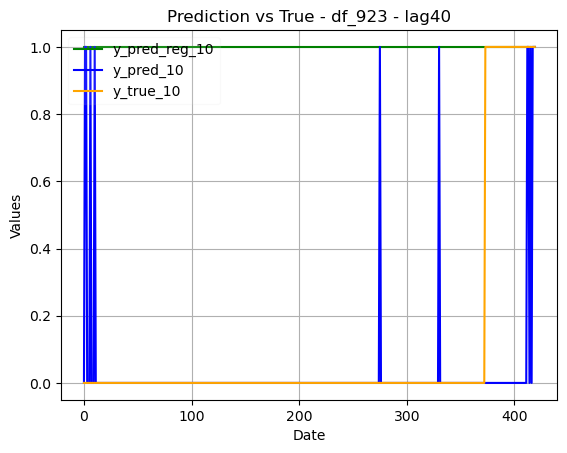

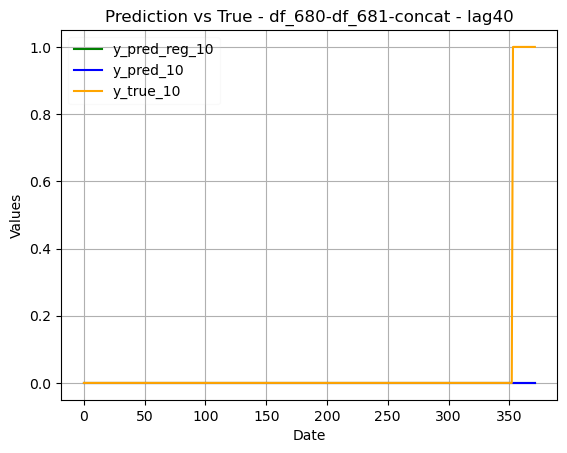

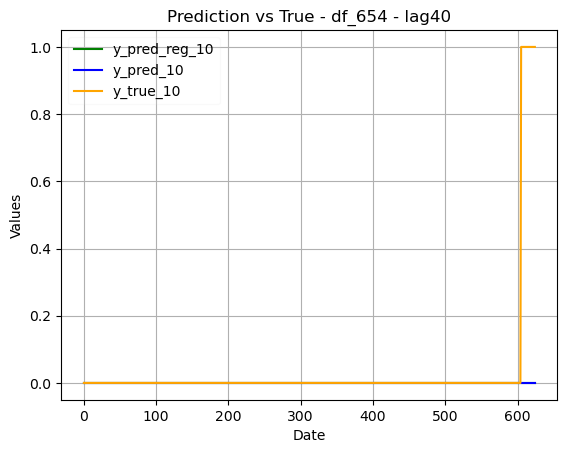

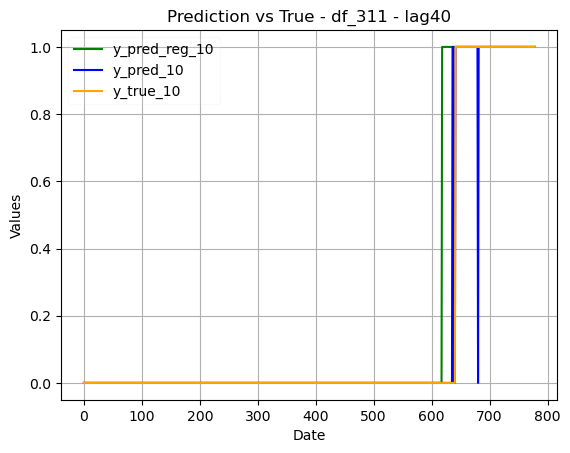

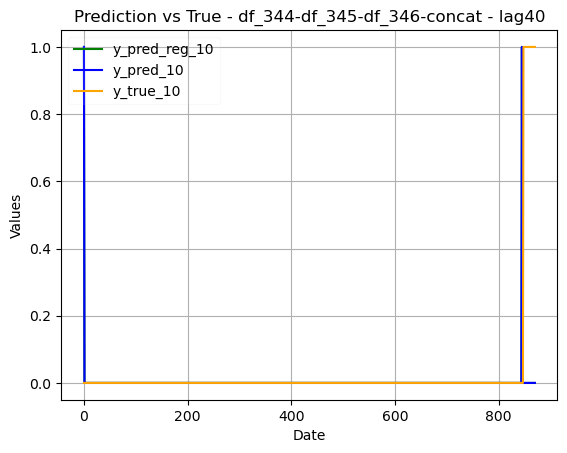

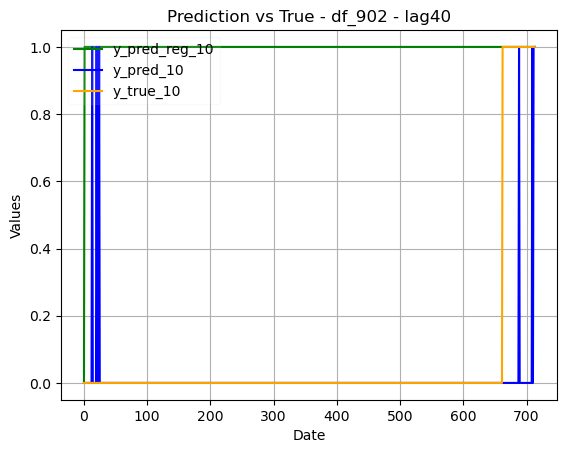

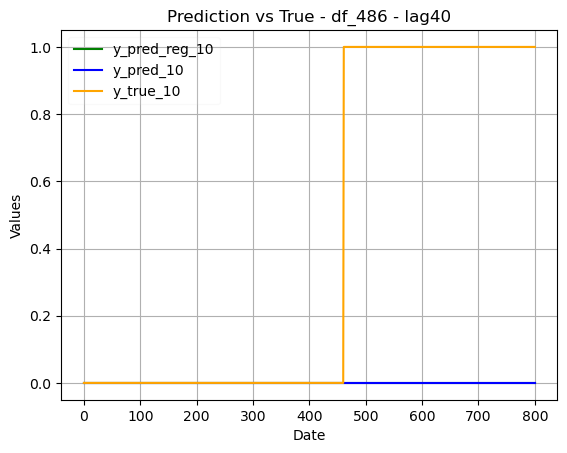

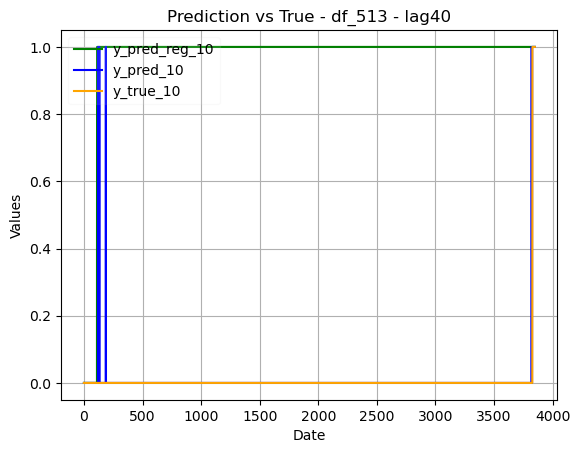

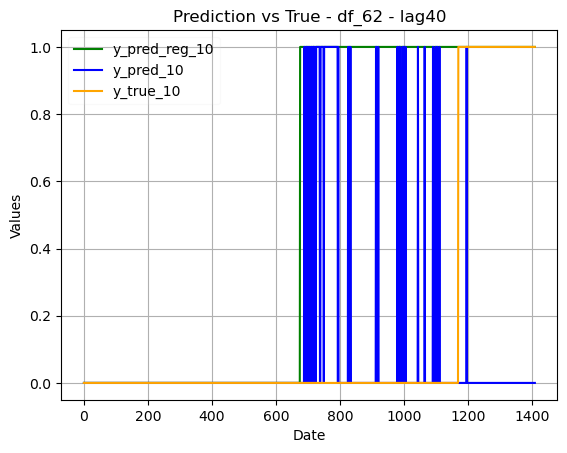

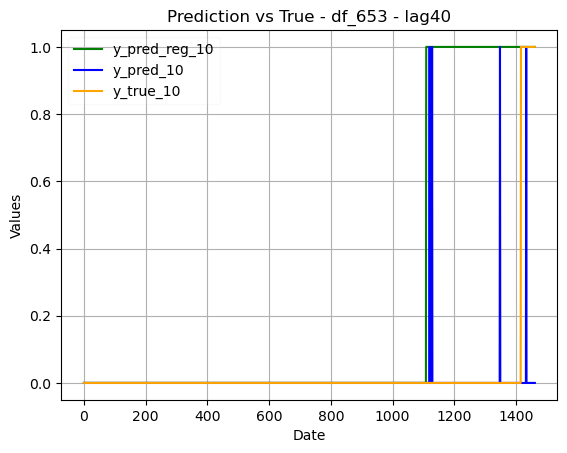

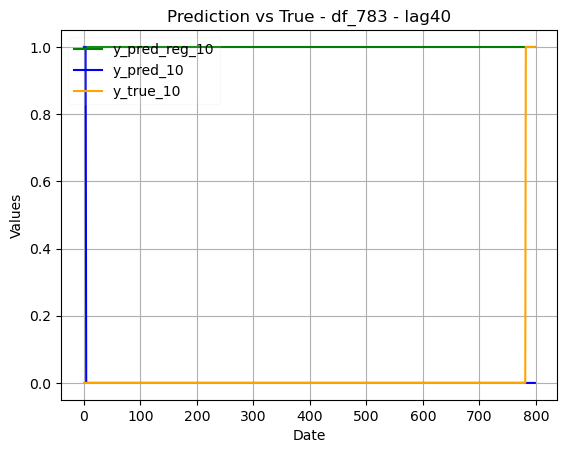

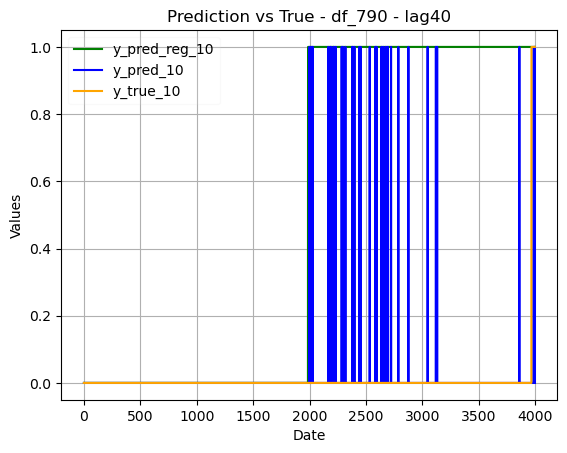

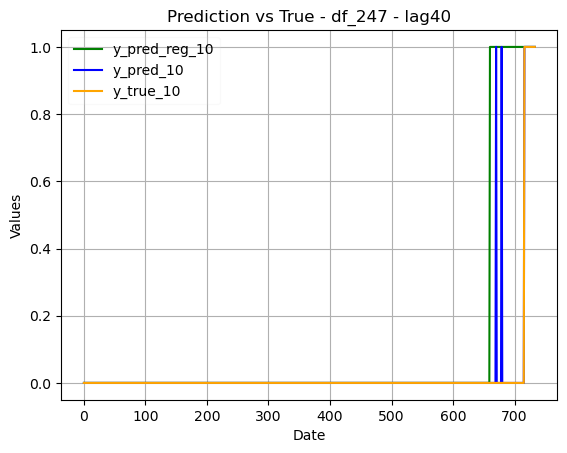

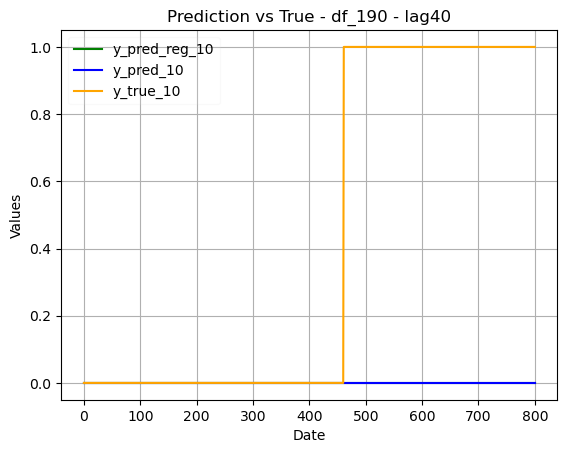

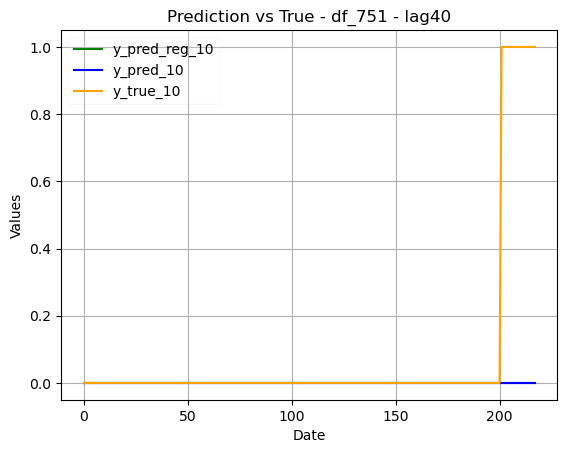

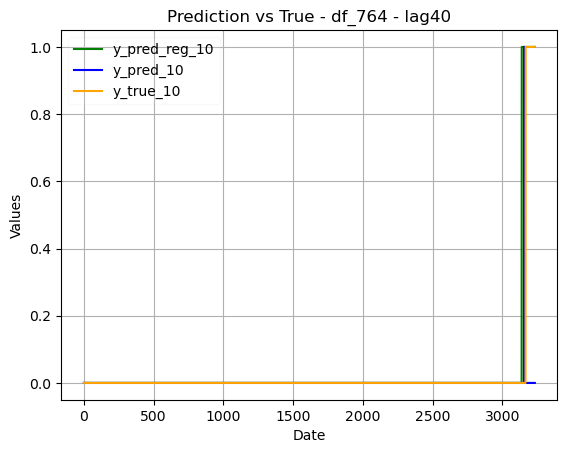

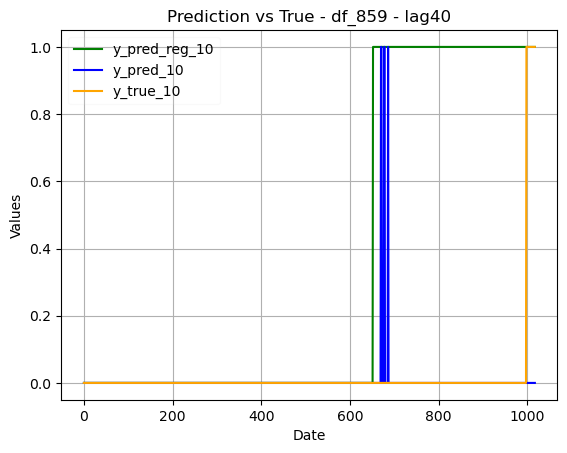

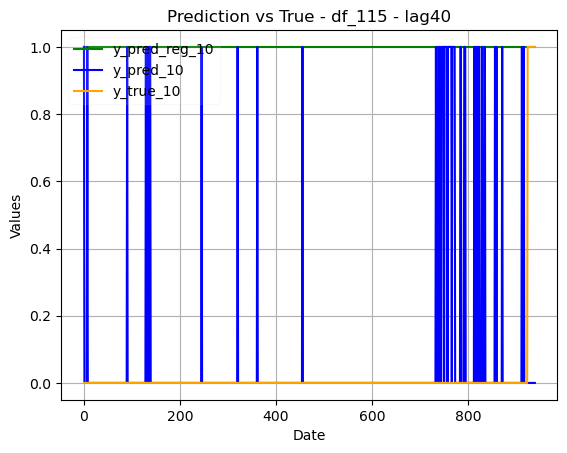

In [4]:
use_threshold = False
reg = 1 # Must be 1 or 0. Parameter to control the oscillation on predictions

'''# Determine the number of plots (one for each key in clot_dict)
num_plots = len(clot_dict)

# Define grid size based on the number of plots
ncols = 2  # Number of columns in the grid (you can adjust)
nrows = math.ceil(num_plots / ncols)  # Calculate rows based on the number of plots and columns

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))

# Flatten the axes array to easily iterate over it if it's more than 1 row/column
axes = axes.flatten()'''



for i, name in enumerate(clot_dict.keys()):
    df = clot_dict[name]
    d_columns = ['P_Effluent','Q_Blood_Pump','Q_Replacement','Q_Dialysate','Q_PBP', 'Q_Patient_Fluid_Removal', 'TMPa']
    df.drop(d_columns, axis=1, inplace=True)

    # Create lagged features for each column except the target column
    for column in df.columns:
        if column != 'Clotting_2':  # Skip the target column
            df[f'{column}_lag_{lag}'] = df[column].shift(lag)
            #df[f'{column}_lag_{lag}_lag_{lag}'] = df[column].shift(lag)

    # Remove rows with NaN values (due to shifting)
    df_lagged = df.dropna()
    df_lagged = df_lagged.reset_index(drop=True)

    # Prepare features (X) and target (y)
    # Drop original columns and only use lagged features
    lagged_columns = [col for col in df_lagged.columns if 'lag_' in col]
    X = df_lagged[lagged_columns]
    X = scaler_loaded.transform(X)
    y_true = df_lagged['Clotting_2'] 



    if use_threshold is False:
        # Make predictions using the lag feature matrix
        y_pred = model_loaded.predict(X)
        
    else:
        # Get predicted probabilities
        probs = model_loaded.predict_proba(X)
        
        # Define a custom threshold, e.g., 0.7
        threshold = 0.7
        
        # Assign Class 1 if the probability for Class 1 is greater than or equal to the threshold, else Class 0
        y_pred = (probs[:, 1] >= threshold).astype(int)
        
    # Regularization on oscillations (on test)
    if reg == 1:
        y_pred_reg = oscillation_red(y_pred, 0.1, 20)
    else:
        y_pred_reg =  y_pred
        
    # Compare y_true with y_pred to see in which points we have the wrong classifications
    # Plotting the two columns
    # Plot each time series in its corresponding subplot
    plt.plot(y_pred_reg, label='y_pred_reg_10', color='green')
    plt.plot(y_pred, label='y_pred_10', color='blue')
    plt.plot(y_true, label='y_true_10', color='orange')
    
    plt.title(f'Prediction vs True - {name} - lag{lag}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend(loc='upper left', framealpha=0.1)
    plt.grid(True)
    plt.savefig(f'{path_to_save}/{name}_{lag}.png', dpi=300)
    plt.show()

